Reference:
Race simulator for Matlab developed by AJK Phillips, 2014.
Credit to AJK Phillips and http://f1metrics.wordpress.com/

The GitHub link below is from another person who uploaded the code by Phillips, who used to put his MATLAB code on Google Drive. (For more details, check the link below)

https://github.com/syllogismos/F1Sim

# RaceSim

For the simulation to run, we need to define the track variables and the driver variables, and import the data we get from DataAnalysis (i.e. the data from Free Practice(s) and Qualifying) to initialize these variables.



## Track Variables

Track variables include:

- Name
- Number of Laps
- Lap Length
- Race Length
- Tyre variables (provided by Pirelli) 
    - Traction
    - Braking
    - Lateral
    - Tyre Stress
    - Track Evolution
    - Asphalt Grip
    - Asphalt Abrasion
    - Downforce

- Fuel Gain (refer to external sources)
- DNF Factor (The likelihood of retirements as race goes on, this value is compounded by laps elapsed (?))
- Safety Car (SC) variables (Could be extended to VSC)
    - Probability of SC
    - Number of Laps per SC period
    - Laptime of SC
    - Closest time gap between cars during the safety car period
    - Pit Window (Laps for pit window under safety car, i.e. Safety Car Window)
    
- Pit variables
    - In lap time loss
    - Out lap time loss
    
- Racing variables
    - Time gained per lap due to DRS
    - Additional tyre wear (in laps) per lap due to DRS
    - Overtaking variables
        - Distance (in seconds) which the car can follow the closest
        - Time loss (in seconds) due to being overtaken. Does not account for resistance (e.g. blocking or slowing down intentionally)
        - Overtaking Threshold (in seconds), i.e. the time needed to attempt to overtake
        
- Start Time standard deviation (???)

- Time difference between fresh tyre compounds
- Relative wear of different compounds
- Wear factor for track (Can be pulled from Pirelli's infographics)

## Driver Variables

Driver variables include:

- name
- Pit Strategy (Predefined, optional strategy)
- Lap Time Standard Deviation, i.e. the variability of their laptimes
- (For plotting) Driver Team Color

## Race Variables

Race variables include:

- Starting Grid Order
- Teammate pairing (Could be considered as a Driver variable)

#### FP2 and Qualifying Teammates Head-to-Head

In [1]:
import fastf1 as ff1
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from race import *
from qualifying import *
from constants import *
from practice import *
from race_sim import *
from scipy import stats
from scipy.optimize import curve_fit
from prediction import *
import itertools

# Enable the cache by providing the name of the cache folder
ff1.Cache.enable_cache('cache')

%store -r fp2_race_sim
%store -r times_df
%store -r driver_stats_df

In [2]:
fp2_race_sim

,Driver,MeanLapTime,SpeedFL,SpeedST,Compound,NoOfLaps,LapTimes,LapNumbers
0,HAM,80.853000,253.0,302.0,MEDIUM,1,[80.85300000000001],[2.0]
1,SAI,83.624000,257.0,NaN,MEDIUM,7,"[83.185, 83.22500000000001, 83.44000000000001,...","[12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0]"
2,LEC,83.698286,253.0,303.0,MEDIUM,7,"[83.57400000000001, 83.552, 83.435, 83.4, 83.7...","[10.0, 11.0, 12.0, 13.0, 15.0, 16.0, 17.0]"
3,BOT,83.834000,255.0,305.0,MEDIUM,1,[83.834],[14.0]
4,NOR,83.917429,253.0,306.0,SOFT,7,"[83.25, 83.333, 84.006, 83.667, 84.56700000000...","[7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 14.0]"
5,OCO,84.055000,253.0,304.0,SOFT,1,[84.055],[10.0]
6,VER,84.173000,255.0,305.0,MEDIUM,8,"[83.771, 83.941, 84.012, 84.18100000000001, 84...","[12.0, 13.0, 14.0, 15.0, 16.0, 18.0, 20.0, 22.0]"
7,RIC,84.187333,255.0,304.0,SOFT,6,"[84.21600000000001, 83.796, 84.15400000000001,...","[6.0, 7.0, 8.0, 9.0, 12.0, 13.0]"
8,VET,84.585000,255.0,305.0,MEDIUM,8,"[84.03500000000001, 84.138, 84.71000000000001,...","[11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0]"
9,PER,84.781500,254.0,306.0,MEDIUM,10,"[84.558, 84.578, 84.39, 84.577, 84.727, 84.972...","[11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 19...."


In [3]:
times_df

,Abbreviation,Q1,Q2,Q3,Fastest Lap
63,RUS,78.407,78.154,77.377,77.377
55,SAI,78.434,77.946,77.421,77.421
16,LEC,78.806,77.768,77.567,77.567
4,NOR,78.653,78.121,77.769,77.769
31,OCO,78.866,78.216,78.018,78.018
14,ALO,78.716,77.904,78.078,77.904
44,HAM,78.374,78.035,78.142,78.035
77,BOT,78.935,78.445,78.157,78.157
3,RIC,78.775,78.198,78.379,78.198
1,VER,78.509,77.703,78.823,77.703


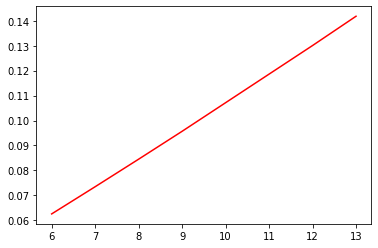

In [4]:
driver = 'RIC'
trackwear = 10

laptimes = fp2_race_sim[fp2_race_sim['Driver'] == driver].LapTimes.tolist()[0]
laps = fp2_race_sim[fp2_race_sim['Driver'] == driver].LapNumbers.tolist()[0]
laptimes = np.array(laptimes)
laps = np.array(laps)




popt, pcov, model = laptime_model(laps, laptimes, trackwear)
plt.plot(laps, model(laps, *popt), 'r-')
plt.show()

In [5]:
teammate_h2h = get_head_to_head_df(fp2_race_sim, times_df)
teammate_h2h

,Driver,GoodFP2,GoodQualifying,Teammate,FP2MeanLapTime,TeammateFP2MeanLapTime,QualifyingLapTime,TeammateQualifyingLapTime,QualifyingPosition,TeammateQualifyingPosition,BaseTime,LongRunEstimate
0,RUS,False,True,HAM,85.315,80.853,77.377,78.035,1,7,85.452722,83.683174
1,SAI,True,True,LEC,83.624,83.698,77.421,77.567,2,3,83.683174,83.705174
2,LEC,True,True,SAI,83.698,83.624,77.567,77.421,3,2,83.808768,83.840971
3,VER,True,True,PER,84.173,84.782,77.703,78.516,10,11,84.181551,84.095363
4,NOR,True,True,RIC,83.917,84.187,77.769,78.198,4,9,84.126123,84.100648
5,ALO,False,True,OCO,85.103,84.055,77.904,78.018,6,5,85.141325,84.210174
6,OCO,False,True,ALO,84.055,85.103,78.018,77.904,5,6,10000.000000,84.324174
7,HAM,False,True,RUS,80.853,85.315,78.035,77.377,7,1,10000.000000,84.341174
8,RIC,True,True,NOR,84.187,83.917,78.198,77.769,9,4,84.420253,84.462214
9,BOT,False,True,ZHO,83.834,85.335,78.157,78.573,8,12,10000.000000,84.463174


In [6]:
# Analyse the stint lengths for each driver
driver_stints_df = pd.DataFrame(columns=['Driver'])
driver_stints_df['Driver'] = ['LEC', 'SAI', 'HAM', 'RUS', 'MAG', 'BOT', 'OCO', 'TSU', 'ALO', 'ZHO', 'MSC', 'STR', 'ALB', 'RIC', 'NOR', 'LAT', 'HUL', 'PER', 'VER', 'GAS', 'VET', 'DEV']

option = 'Rep'

for compound in DRY_TYRES + ['Total']:
    driver_stints_df['LapsPer' + compound.title() + 'Stint'] = driver_stats_df[compound.title() +  'Laps' + option] / driver_stats_df[compound.title() + 'Stints' + option]

# Drop DEV and HUL for now, since they're stand-ins
driver_stints_df.drop(16, inplace=True)
driver_stints_df.drop(21, inplace=True)
    
for compound in DRY_TYRES + ['Total']:
    driver_stints_df[compound.title() + 'DegFactor'] = driver_stints_df['LapsPer' + compound.title() + 'Stint'] / (driver_stints_df['LapsPer' + compound.title() + 'Stint'].mean())

total_deg_factor = 0
for compound in DRY_TYRES:
    total_deg_factor += driver_stints_df[compound.title() + 'DegFactor']
driver_stints_df['AverageDegFactor'] = total_deg_factor / 3

driver_stints_df.sort_values('AverageDegFactor')

,Driver,LapsPerSoftStint,LapsPerMediumStint,LapsPerHardStint,LapsPerTotalStint,SoftDegFactor,MediumDegFactor,HardDegFactor,TotalDegFactor,AverageDegFactor
9,ZHO,7.666667,18.444444,21.200000,17.352941,0.575981,1.046165,0.868525,0.918748,0.830224
18,VER,9.857143,15.666667,21.142857,15.576923,0.740546,0.888610,0.866184,0.824717,0.831780
8,ALO,12.400000,18.000000,17.000000,16.434783,0.931586,1.020956,0.696459,0.870136,0.883000
10,MSC,13.000000,16.000000,18.833333,16.100000,0.976663,0.907516,0.771567,0.852411,0.885249
17,PER,11.500000,20.700000,17.000000,17.181818,0.863971,1.174099,0.696459,0.909687,0.911510
7,TSU,12.555556,16.125000,22.333333,16.347826,0.943272,0.914606,0.914956,0.865532,0.924278
13,RIC,13.500000,14.555556,23.111111,17.500000,1.014227,0.825588,0.946820,0.926534,0.928878
12,ALB,9.800000,16.666667,28.166667,18.400000,0.736253,0.945330,1.153937,0.974184,0.945173
2,HAM,11.600000,19.000000,23.125000,18.826087,0.871484,1.077676,0.947389,0.996743,0.965516
3,RUS,10.250000,19.444444,26.285714,20.000000,0.770061,1.102884,1.076878,1.058895,0.983274


In [53]:
driver_tyre_data = (driver_stints_df.merge(teammate_h2h, how='inner', on=['Driver']))[['Driver', 'SoftDegFactor', 'MediumDegFactor', 'HardDegFactor', 'TotalDegFactor', 'LongRunEstimate']]
driver_tyre_data

,Driver,SoftDegFactor,MediumDegFactor,HardDegFactor,TotalDegFactor,LongRunEstimate
0,LEC,1.145700,0.888610,0.989089,0.982126,83.840971
1,SAI,1.051791,0.923722,1.097947,0.990379,83.705174
2,HAM,0.871484,1.077676,0.947389,0.996743,84.341174
3,RUS,0.770061,1.102884,1.076878,1.058895,83.683174
4,MAG,1.352302,0.958564,1.249530,1.141254,85.475517
5,BOT,0.701194,1.354972,1.126625,1.200082,84.463174
6,OCO,1.014227,1.096582,0.891058,0.987535,84.324174
7,TSU,0.943272,0.914606,0.914956,0.865532,85.458108
8,ALO,0.931586,1.020956,0.696459,0.870136,84.210174
9,ZHO,0.575981,1.046165,0.868525,0.918748,84.879174


In [45]:
driver_tyre_data['OptimalStrategy'] = np.nan
driver_tyre_data['OptimalStrategy'] = driver_tyre_data['OptimalStrategy'].astype('object')

Driver              object
SoftDegFactor      float64
MediumDegFactor    float64
HardDegFactor      float64
LongRunEstimate    float64
OptimalStrategy     object
dtype: object

In [83]:
# Track data for Hungary
# Can be changed for different tracks
IN_LAP = 2.5
OUT_LAP = 16.5
START_TIME = 6
NO_OF_LAPS = 70
MAX_PIT_TIMES = 6


one_stop_combinations = list(itertools.combinations(DRY_TYRES, 2))
one_stop_combinations

two_stop_combinations = list(itertools.combinations_with_replacement(DRY_TYRES, 3))
for combination in two_stop_combinations:
    if (len(set(combination)) == 1):
        two_stop_combinations.remove(combination)
        
two_stop_combinations

[('SOFT', 'SOFT', 'MEDIUM'),
 ('SOFT', 'SOFT', 'HARD'),
 ('SOFT', 'MEDIUM', 'MEDIUM'),
 ('SOFT', 'MEDIUM', 'HARD'),
 ('SOFT', 'HARD', 'HARD'),
 ('MEDIUM', 'MEDIUM', 'HARD'),
 ('MEDIUM', 'HARD', 'HARD')]

In [86]:
# TODO: do a 1 stopper strategy first


driver_strategy_df = pd.DataFrame(columns=['Driver', 'QuickestTime', 'QuickestStrategy', 'Quickest1StopTime', 'Quickest1StopStrategy', 'Quickest2StopTime',' Quickest2StopStrategy'])

deg_model = np.vectorize(tyre_degradation_model)

for driver in get_all_driver_names(driver_tyre_data):
    soft_deg_factor = float(driver_tyre_data.loc[driver_tyre_data['Driver'] == driver, 'SoftDegFactor'])
    medium_deg_factor = float(driver_tyre_data.loc[driver_tyre_data['Driver'] == driver, 'MediumDegFactor'])
    hard_deg_factor = float(driver_tyre_data.loc[driver_tyre_data['Driver'] == driver, 'HardDegFactor'])
    total_deg_factor = float(driver_tyre_data.loc[driver_tyre_data['Driver'] == driver, 'TotalDegFactor'])
    deg_dict = {SOFT: soft_deg_factor, MEDIUM: medium_deg_factor, HARD: hard_deg_factor}
    
    curr_min_fastest_time = 99999
    curr_min_fastest_tyre_combination = 'NA'
    '''
    One Stop Strategy
    '''
    no_of_stops = 1
    long_runs = float(driver_tyre_data.loc[driver_tyre_data['Driver'] == driver, 'LongRunEstimate'])
    race_base_times = long_runs * 70 + no_of_stops * (IN_LAP + OUT_LAP+1) + START_TIME

    curr_1_stop_fastest_time = 99999
    curr_1_stop_fastest_tyre_combination = 'NA'
    
    for stint_1_laps in range(1, NO_OF_LAPS):
        stint_2_laps =  NO_OF_LAPS - stint_1_laps

        for combination in one_stop_combinations:

            first_set =  combination[0]
            second_set = combination[1]

            first_stint = np.arange(1, stint_1_laps + 1)
            second_stint = np.arange(1, stint_2_laps + 1)

            run_time = sum(deg_model(first_stint, first_set, deg_dict[first_set])) + \
                                    sum(deg_model(second_stint, second_set, deg_dict[second_set])) + \
                                    race_base_times

            if run_time < curr_min_fastest_time:
                curr_min_fastest_time = run_time
                curr_min_fastest_tyre_combination = '{} {} {} {}'.format(first_set, stint_1_laps, second_set, stint_2_laps)
            if run_time < curr_1_stop_fastest_time:
                curr_1_stop_fastest_time = run_time
                curr_1_stop_fastest_tyre_combination = '{} {} {} {}'.format(first_set, stint_1_laps, second_set, stint_2_laps)
                
                
    '''
    Two Stop Strategy
    '''            
    no_of_stops = 2
    long_runs = float(driver_tyre_data.loc[driver_tyre_data['Driver'] == driver, 'LongRunEstimate'])
    race_base_times = long_runs * 70 + no_of_stops * (IN_LAP + OUT_LAP+1) + START_TIME

    curr_2_stop_fastest_time = 99999
    curr_2_stop_fastest_tyre_combination = 'NA'
    
    for stint_1_laps in range(1, NO_OF_LAPS):
        for stint_2_laps in range(1, NO_OF_LAPS - stint_1_laps):
            stint_3_laps = NO_OF_LAPS - stint_1_laps - stint_2_laps
        

            for combination in two_stop_combinations:

                first_set =  combination[0]
                second_set = combination[1]
                third_set = combination[2]

                first_stint = np.arange(1, stint_1_laps + 1)
                second_stint = np.arange(1, stint_2_laps + 1)
                third_stint = np.arange(1, stint_3_laps + 1)

                run_time = sum(deg_model(first_stint, first_set, deg_dict[first_set])) + \
                                        sum(deg_model(second_stint, second_set, deg_dict[second_set])) + \
                                        sum(deg_model(third_stint, third_set, deg_dict[third_set])) + \
                                        race_base_times

                if run_time < curr_min_fastest_time:
                    curr_min_fastest_time = run_time
                    curr_min_fastest_tyre_combination = '{} {} {} {} {} {}'.format(first_set, stint_1_laps, second_set, stint_2_laps, third_set, stint_3_laps)
                if run_time < curr_2_stop_fastest_time:
                    curr_2_stop_fastest_time = run_time
                    curr_2_stop_fastest_tyre_combination = '{} {} {} {} {} {}'.format(first_set, stint_1_laps, second_set, stint_2_laps, third_set, stint_3_laps)
                
                
        
    driver_strategy_df.loc[len(driver_strategy_df)]= [driver, curr_min_fastest_time, curr_min_fastest_tyre_combination,
                                                     curr_1_stop_fastest_time, curr_1_stop_fastest_tyre_combination, 
                                                      curr_2_stop_fastest_time, curr_2_stop_fastest_tyre_combination]
    
driver_strategy_df = driver_strategy_df.sort_values('QuickestTime')
driver_strategy_df.reset_index(inplace=True, drop=True)
driver_strategy_df

,Driver,QuickestTime,QuickestStrategy,Quickest1StopTime,Quickest1StopStrategy,Quickest2StopTime,Quickest2StopStrategy
0,SAI,5879.989158,SOFT 21 SOFT 22 MEDIUM 27,5885.830444,SOFT 21 HARD 49,5879.989158,SOFT 21 SOFT 22 MEDIUM 27
1,LEC,5885.375877,SOFT 23 SOFT 23 MEDIUM 24,5894.608701,SOFT 23 HARD 47,5885.375877,SOFT 23 SOFT 23 MEDIUM 24
2,RUS,5889.450904,SOFT 14 MEDIUM 28 MEDIUM 28,5891.460487,MEDIUM 29 HARD 41,5889.450904,SOFT 14 MEDIUM 28 MEDIUM 28
3,NOR,5905.378187,SOFT 19 SOFT 19 MEDIUM 32,5913.292362,SOFT 24 MEDIUM 46,5905.378187,SOFT 19 SOFT 19 MEDIUM 32
4,ALO,5919.848957,SOFT 19 SOFT 20 MEDIUM 31,5933.807364,SOFT 25 MEDIUM 45,5919.848957,SOFT 19 SOFT 20 MEDIUM 31
5,OCO,5922.140427,SOFT 20 SOFT 20 MEDIUM 30,5933.836416,SOFT 25 MEDIUM 45,5922.140427,SOFT 20 SOFT 20 MEDIUM 30
6,VER,5926.206920,SOFT 15 MEDIUM 27 MEDIUM 28,5926.855622,SOFT 16 HARD 54,5926.206920,SOFT 15 MEDIUM 27 MEDIUM 28
7,VET,5928.090184,SOFT 25 SOFT 25 MEDIUM 20,5939.742747,SOFT 33 MEDIUM 37,5928.090184,SOFT 25 SOFT 25 MEDIUM 20
8,HAM,5931.128549,SOFT 18 SOFT 18 MEDIUM 34,5937.941987,SOFT 18 HARD 52,5931.128549,SOFT 18 SOFT 18 MEDIUM 34
9,RIC,5937.179171,SOFT 22 SOFT 22 MEDIUM 26,5942.384450,SOFT 21 HARD 49,5937.179171,SOFT 22 SOFT 22 MEDIUM 26
